# Урок 7. Детектирование объектов

### 1. Сделайте краткий обзор любой статьи посвященной тому или иному алгоритму для object detection, который не рассматривался на уроке. Проведите анализ: Чем отличается выбранная вами на рассмотрение архитектура нейронной сети от других архитектур? В чем плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при применении данной архитектуры на практике?

Я решил подробнее разобраться, как в старших поколениях сетей R-CNN (Fast R-CNN и Faster R-CNN) происходит нахождение областей интереса. На вебинаре не уловил, с помощью каких технологий это происходит.


*   Fast R-CNN. В этой архитектуре, в отличие от R-CNN, сверточная сеть проходит всего один раз по всему изображению, а далее области интереса ищутся уже в пространстве сформированных признаков. Просмотрев несколько статей, я не увидел конкретного указания, каким механизмом именно этот поиск происходит. Но везде рассказ велся в сравнении с R-CNN, и я сделал вывод, что поиск областей интереса происходит также по технологии Selective Search. С той лишь разницей, что поиск ведется не по исходной картинке, а по пространству признаков созданных сверточным слоем. Далее с каждой областью интереса работает специальный RoI-Pulling слой. Его суть заключается в том, чтобы из областей разного размера получить одинаковые по размеру вектора, приходящие в полносвязные слои.
*   Faster R-CNN. Эта сеть полностью отказывается от классических методов обнаружения областей интереса. За это отвечает отдельная сеть RPN (Region Propocal Networks). Она разделена на два потока - первый классифицирует признаки (передний план и фон) в фиксированных якорях-регионах, второй подготавливает данные для смещения этих якорей и получения более точных регионов. Эти потоки сходятся в Proposal-блоке, который синтезирует уточненные с помощью регрессии области с объектами переднего плана, а также исключает фон и слишком малые объекты. Далее, как и в Fast R-CNN, работает RoI-Pulling слой и классификация объекта с регрессией рамки.



### 2. Запустите детектор (ssdMobile_v2 или faster_rcnn, или любой другой детектор) для своей картинки и попробуйте найти 10 объектов, 100 объектов.

In [1]:
#Импорт всего

# Currently %tensorflow_version 2.x installs beta1, which doesn't work here.
# %tensorflow_version can likely be used after 2.0rc0  
#!pip install tf-nightly-gpu-2.0-preview
#!pip install tf-nightly-gpu-2.0-preview
from __future__ import absolute_import, division, print_function, unicode_literals

# For running inference on the TF-Hub module.
import tensorflow as tf
from tensorflow.keras.preprocessing import image

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time
%matplotlib inline


In [2]:
# выводит картинку
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

#  Рисуем рамку на изображении
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = bottom + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

#  Рисуем все рамки
# max_boxes - максимальное число объектов для отображения, min_score=0.01 - минимакльная точность их детекции
# можно менять

def draw_boxes(image, boxes, class_names, scores, max_boxes=3, min_score=0.01):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

In [15]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" # param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [4]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [5]:
def run_detector(detector, path, max_boxes=20, min_score=0.1):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()
  #print(result['detection_scores'])
  result = {key:value.numpy() for key,value in result.items()} 

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"], max_boxes=max_boxes, min_score=min_score)

  display_image(image_with_boxes)
  return result

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
PATH = '/content/drive/My Drive/GeekBrains/NeuralNetworkIntro/754678789049967.jpeg'

In [8]:
img = image.load_img(PATH)

Взял сложную картинку, где очень много объектов:

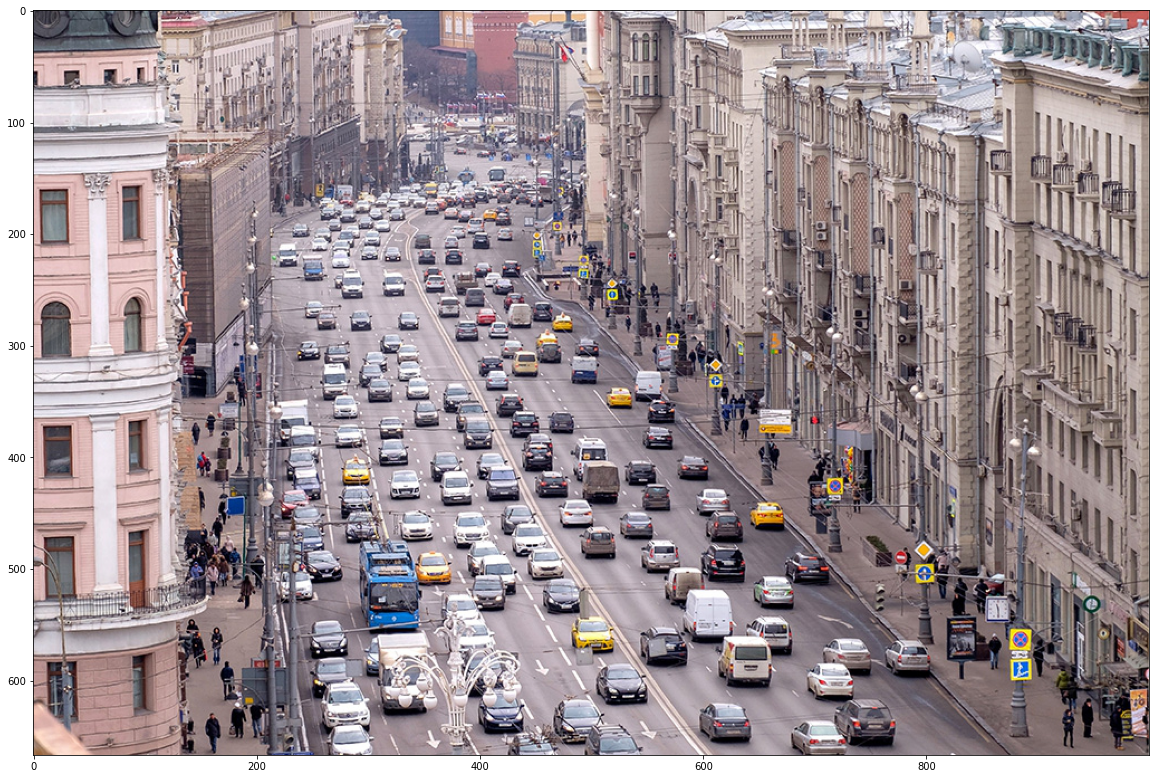

In [9]:
display_image(img)

Найдем 10 объектов:

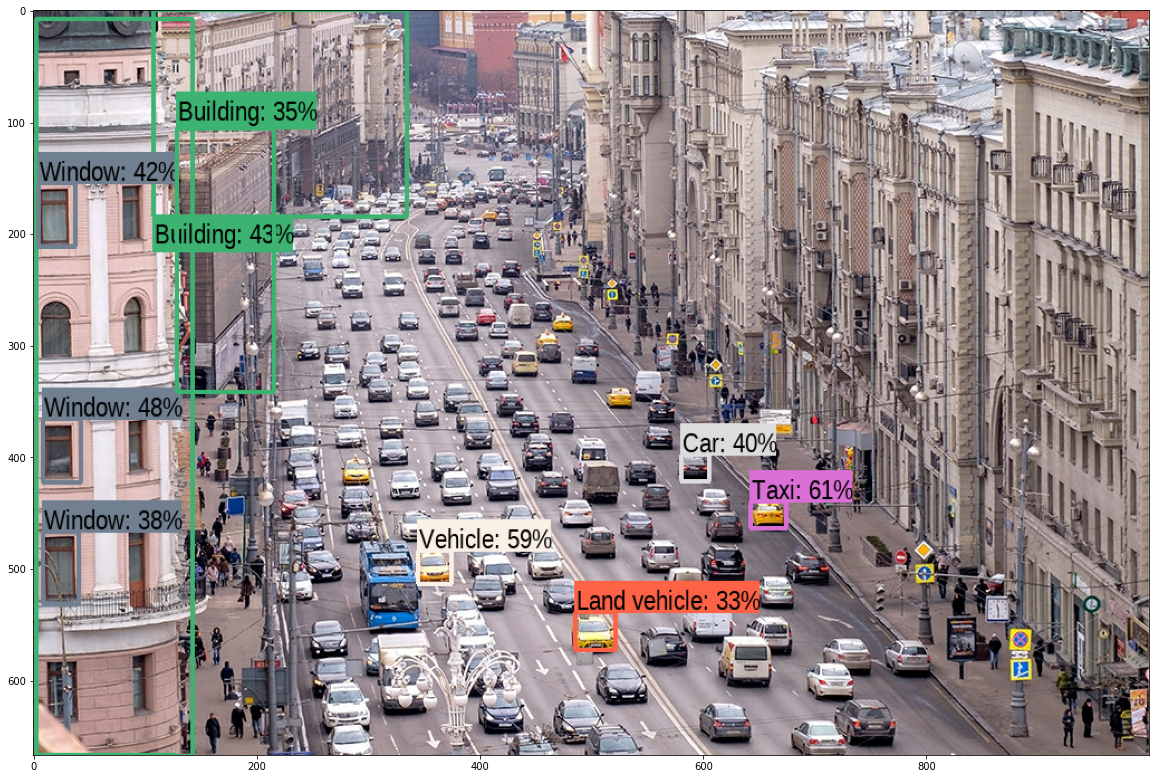

In [16]:
result1 = run_detector(detector, PATH, max_boxes=10, min_score=0.1)

Найдем 100 объектов:

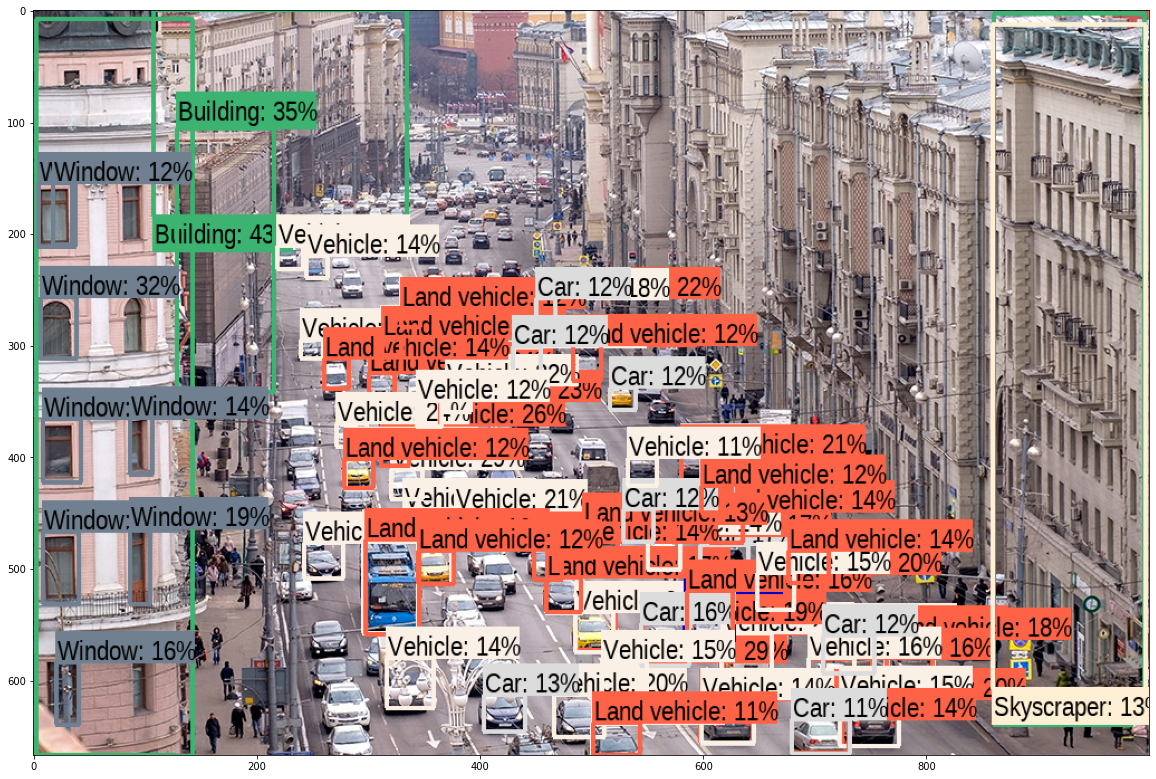

In [17]:
result2 = run_detector(detector, PATH, max_boxes=100, min_score=0.1)

Как и ожидалось, в основном сеть нашла автомобили. Забавно, что среди авто, сеть нашла три класса - собственно автомобили, транспортные средства и наземные транспортные средства.

Но вот людей сеть не нашла, видимо, слишком маленькие на изображении.

Также забавно, что на Тверской улице сеть нашла один небоскреб.

Сеть SSDMobile дала худшие результаты, чем Faster RCNN.